In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
df_raw = pd.read_csv('data/missoula_valley_monitored_wells.csv', parse_dates=['time'], index_col='time')
df_filled = pd.read_csv('data/missoula_valley_wells_imputed_qreg.csv')
df_pump = pd.read_csv('data/mso_monthly_pumping_rates.csv')

### Heatmap of all data and gaps

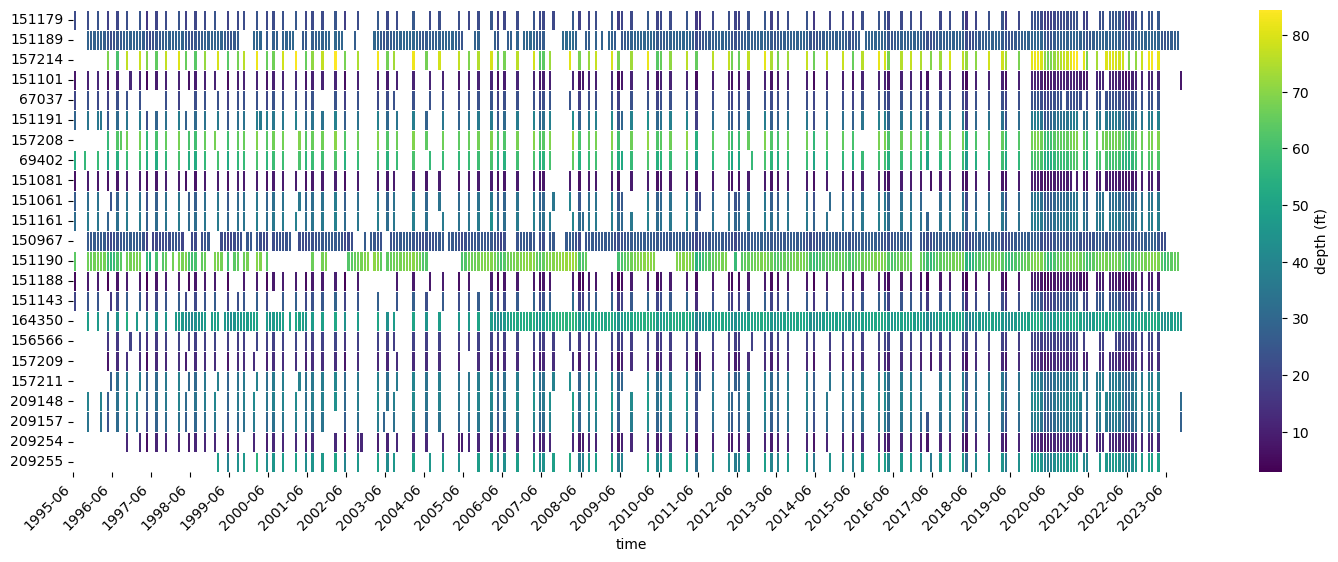

In [3]:
fig, ax = plt.subplots(figsize=(18, 6))
fig = sns.heatmap(df_raw.transpose(), 
                  cmap='viridis', 
                  cbar=True, 
                  linewidth=0.5, 
                  ax=ax, 
                  cbar_kws={'label': 'depth (ft)'})
xdates = df_raw.index.strftime('%Y-%m').sort_values().unique()
step = 12
ax.set_xticks(np.arange(0, len(xdates), step=step))
ax.set_xticklabels(xdates[::step], rotation=45, ha='right')
plt.show()

### Plot timeseries of all wells

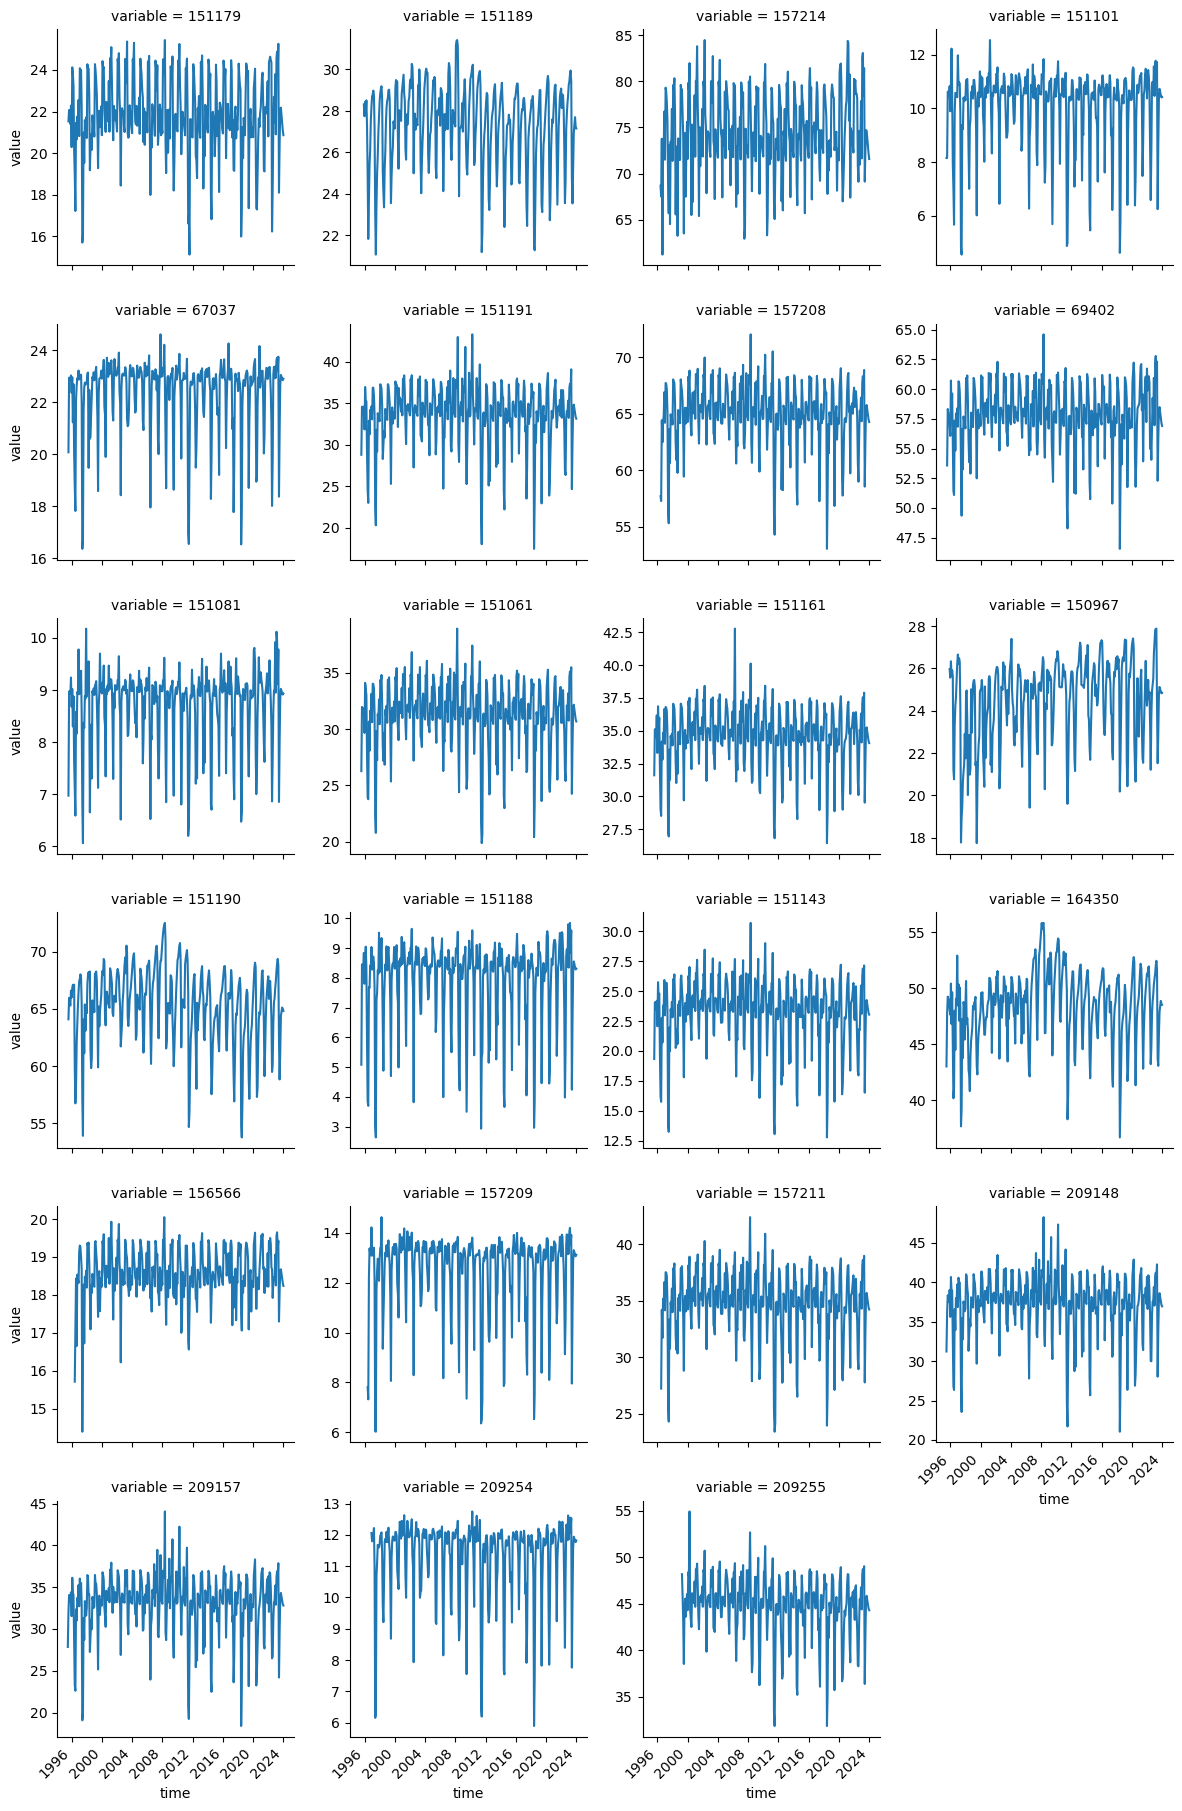

In [29]:
df_melt = df_filled.drop(columns='Q').melt(id_vars='time')
df_melt['time'] = pd.to_datetime(df_melt['time'])
g = sns.FacetGrid(df_melt, col='variable', col_wrap=4, sharey=False, sharex=True)
g.map(plt.plot, 'time', 'value')
# Rotate the x-tick labels on all subplots
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')
plt.show()